# Accuinsight+ Modeler AutoDL tutorial
## 서울의 2019년 일별 평균 기온을 예측하는 RNN 모델
## 목차
1. [분석 개요](#RNN_분석_개요)
2. [데이터](#RNN_데이터)
3. [RNN 모델 생성 및 학습](#RNN_모델_구성_및_학습)
4. [학습 결과 시각화](#RNN_학습_결과_시각화)
5. [Modeler AutoDL 사용방법](#AutoDL_사용방법)

<a id='RNN_분석_개요'></a>
## 분석 개요
- 본 예제에서는 기상청 기상자료개방포털에서 제공하는 [서울 평균기온 데이터](https://data.kma.go.kr/stcs/grnd/grndTaList.do?pgmNo=70)를 사용해 서울의 일별 평균기온을 예측하는 2-layer RNN 모델을 만들고,  
  Accuinsight+ Modeler의 AutoDL 기능을 사용하여 하이퍼파라미터를 최적화하는 과정을 설명합니다.
- 2009년부터 2018년까지 9년 간 서울의 평균기온 데이터를 학습 데이터로 사용하여 2019년의 평균기온을 예측합니다.

In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

import numpy as np
import pandas as pd
import easydict
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<a id='RNN_데이터'></a>
## 데이터

2009년부터 2019년까지 10년 간 서울의 평균기온 데이터입니다.

In [2]:
temp = pd.read_csv("data/seoul_temperature.csv")
temp["날짜"] = pd.to_datetime(temp["날짜"])
temp = temp.set_index("날짜")
temp = pd.DataFrame(temp["평균기온(℃)"])
temp

,평균기온(℃)
날짜,
2009-01-01,-5.8
2009-01-02,-2.8
2009-01-03,-1.0
2009-01-04,0.4
2009-01-05,-1.6
...,...
2019-12-27,-1.7
2019-12-28,1.1
2019-12-29,3.8


계절성 패턴을 갖는 시계열 데이터입니다.

/opt/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


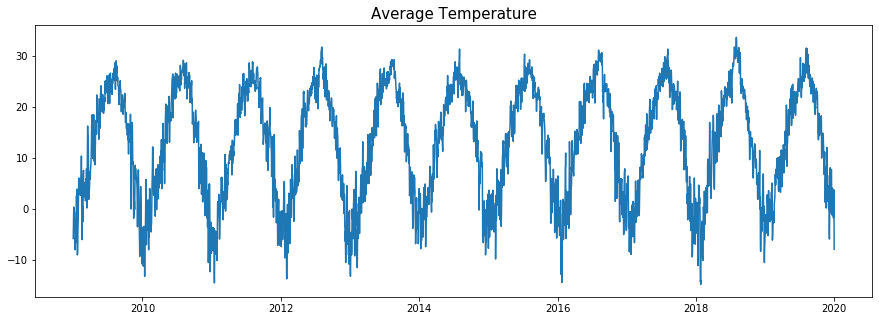

In [3]:
plt.figure(figsize=(15,5))
plt.plot(temp.index, temp["평균기온(℃)"])
plt.title('Average Temperature', fontsize=15);

#### train/test dataset 분리
- train dataset: 2009년~2018년  
- test dataset: 2019년

In [5]:
train_df = temp[:3652]
test_df = temp[3652:]

#### Min-Max Scaling

In [6]:
transformer = MinMaxScaler()
train = transformer.fit_transform(train_df)
test = transformer.transform(test_df)

- 본 예제에서는 모델 학습과 관련된 하이퍼파라미터인 epochs, batch size, learning_rate와  
  모델 구조를 결정하는 하이퍼파라미터인 num_nodes, sequence_length, rnn_cell을 최적화합니다.
  - `num_nodes`: RNN layer의 노드 개수
  - `sequnece_length`: 예측에 사용할 과거 정보의 길이
  - `rnn_cell`: RNN, LSTM, GRU 중에서 선택 ([이미지 출처](http://dprogrammer.org/rnn-lstm-gru))
- AutoDL을 사용하기 위해서는 __argparse__를 통해 하이퍼파라미터를 설정해야 하는데,  
  jupyter notebook에서는 argparse 사용이 불가능하기 때문에 __easydict__를 통해 하이퍼파라미터를 설정합니다.  
  실제로 AutoDL에 사용되는 [autodl_rnn_temperature_regression.py](autodl_rnn_temperature_regression.py)에서는 argparse를 통해 하이퍼파라미터를 설정합니다.
<p align="center">
    <img src="pic/rnn_lstm_gru.png" height="750px" width="850px">
</p>

In [4]:
args = easydict.EasyDict({
    "sequence_length": 7,
    "num_nodes": 30,
    "rnn_cell": "LSTM",
    "learning_rate": 0.0001,
    "batch_size": 64,
    "epochs": 20})

#### sequence_length 값에 따라 데이터 재구성
- sequence_length의 default 값은 7입니다.
- sequence_length의 값이 7이면 이전 7일 간의 평균기온 데이터를 사용해 다음 날의 평균기온을 예측합니다.

In [7]:
window_length = args.sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1, :])
    y_train.append(window[-1, [-1]])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1, :])
    y_test.append(window[-1, [-1]])
x_test = np.array(x_test)
y_test = np.array(y_test)

<a id='RNN_모델_구성_및_학습'></a>
## RNN 모델 생성 및 학습

In [8]:
if args.rnn_cell == "LSTM":
    rnn_cell = tf.keras.layers.LSTM
elif args.rnn_cell == "GRU":
    rnn_cell = tf.keras.layers.GRU
elif args.rnn_cell == "RNN":
    rnn_cell = tf.keras.layers.RNN

In [9]:
model = tf.keras.models.Sequential([
    rnn_cell(args.num_nodes, return_sequences=True, input_shape=(args.sequence_length, 1)),
    rnn_cell(args.num_nodes),
    tf.keras.layers.Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


- AutoDL에서 평가 지표를 수집할 수 있도록 epoch이 종료될 때마다 평가 지표(Loss)를 출력합니다.
- 이번 예제에서는 __평가 지표명=평가 지표값__ 형식으로 평가 지표를 출력하는데,  
  평가 지표 설정 방법은 [Modeler AutoDL 사용방법](#AutoDL_사용방법) 챕터에서 좀 더 자세히 다룰 것입니다.

In [15]:
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch {}".format(epoch + 1))
        print("Train-loss={:.4f}".format(logs['loss']))
        print("Validation-loss={:.4f}".format(logs['val_loss']))

In [16]:
model.fit(x_train, y_train,
          epochs=args.epochs,
          batch_size=args.batch_size,
          validation_data=(x_test, y_test),
          shuffle=False,
          callbacks=[MetricHistory()])

Epoch 1/20
55/57 [===========================>..] - ETA: 0s - loss: 0.0083
Epoch 1
Train-loss=0.0082
Validation-loss=0.0044
57/57 [==============================] - 1s 17ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 2/20
55/57 [===========================>..] - ETA: 0s - loss: 0.0057
Epoch 2
Train-loss=0.0057
Validation-loss=0.0038
57/57 [==============================] - 1s 17ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 3/20
55/57 [===========================>..] - ETA: 0s - loss: 0.0054
Epoch 3
Train-loss=0.0054
Validation-loss=0.0038
57/57 [==============================] - 1s 16ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 4/20
56/57 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 4
Train-loss=0.0053
Validation-loss=0.0038
57/57 [==============================] - 1s 16ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 5/20
56/57 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 5
Train-loss=0.0053
Validation-loss=0.0038
57/57 [=====================

<a id='RNN_학습_결과_시각화'></a>
## 학습 결과 시각화

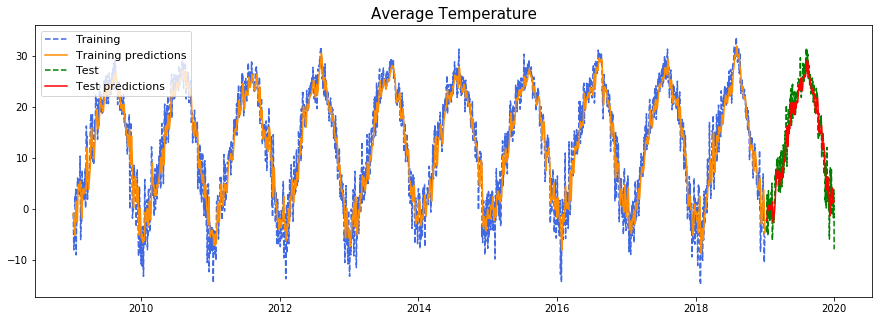

In [17]:
train_prediction = model.predict(x_train, batch_size=64)
test_prediction = model.predict(x_test, batch_size=64)
plt.figure(figsize=(15,5))
plt.plot(train_df.index[7:], transformer.inverse_transform(y_train), '--', c='royalblue',
         label='Training')
plt.plot(train_df.index[7:], transformer.inverse_transform(train_prediction), c='darkorange',
         label='Training predictions')
plt.plot(test_df.index[7:], transformer.inverse_transform(y_test), '--', c='green',
         label='Test')
plt.plot(test_df.index[7:], transformer.inverse_transform(test_prediction), c='red',
         label='Test predictions')
plt.legend(fontsize=11, loc='upper left');
plt.title('Average Temperature', fontsize=15);
plt.show()

<a id='AutoDL_사용방법'></a>
## Modeler AutoDL 사용방법
- 지금까지 서울의 일별 평균기온을 예측하는 RNN 모델 예제를 살펴보았습니다.
- 이번 챕터에서는 위에서 살펴본 RNN 모델의 하이퍼파라미터를 AutoDL 기능을 사용해 최적화하는 과정에 대해 다룰 것입니다.